In [1]:
from rich.jupyter import print
from rich.markdown import Markdown

import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import os
import numpy as np
import matplotlib.pyplot as plt

from matplotlib.pyplot import figure

def get_files(dir_path):
    file_list = os.listdir(dir_path)
    all_files = list()
    # Iterate over all the entries
    for entry in file_list:
        # Create full path
        full_path = os.path.join(dir_path, entry)
        # If entry is a directory then get the list of files in this directory 
        if os.path.isdir(full_path):
            all_files = all_files + get_files(full_path)
        else:
            all_files.append(full_path)
                
    return all_files

def get_latency_files(files):
    return [file for file in files if "clean_pub_0" in file]

def summarise_data(files, title):
    print(Markdown("# " + title))
    for file in files:
        df = pd.read_csv(file)["Latency"]
        print(Markdown("## " + os.path.basename(os.path.dirname(file)).replace("_", " ").capitalize()))
        print(df.describe().to_markdown())

def plot_mean(ax, df):
    mean = df.mean()
    formatted_mean = '{0:.0f}'.format(mean)
    x_width = len(df.index)
    ax.axhline(mean, 0, x_width, color="red", linewidth=2)
    ax.text(x_width * 0, mean, "Mean: " + str(formatted_mean), color='white', backgroundcolor='red', fontweight='bold', fontsize=12)

def plot_std(ax, df):
    std = df.std()
    formatted_std = '{0:.0f}'.format(std)
    x = len(df.index) * 0.9
    y = df.max()
    ax.text(x, y, "std: " + str(formatted_std), color='white', backgroundcolor='red', fontweight='bold', fontsize=12)

def plot_quantile(ax, df, quantile):
    quantile_value = df.quantile(quantile)
    x_width = len(df.index)
    x = x_width * quantile
    y = quantile_value
    ax.text(x, y, str('{0:.0f}'.format(quantile * 100)) + '%: ' + str('{0:.0f}'.format(quantile_value)), color='white', backgroundcolor='red', fontweight='bold', fontsize=12)

def plot_min(ax, df):
    min = df.min()
    x = 0
    y = min
    ax.text(x, y, 'min: ' + str('{0:.0f}'.format(min)), color='white', backgroundcolor='red', fontweight='bold', fontsize=12)

def plot_max(ax, df):
    max = df.max()
    x = 0
    y = max
    ax.text(x, y, 'max: ' + str('{0:.0f}'.format(max)), color='white', backgroundcolor='red', fontweight='bold', fontsize=12)

def plot_data(title, file, axes, index, color, type):
    df = pd.read_csv(file)["Latency"]
    ax = axes[index]
    
    if 'cdf' in type:
        cdf = df.value_counts().sort_index().cumsum() / df.shape[0]
        cdf.plot(ax = ax)
        ax.set_xlabel("Latency ($\mu$s)")
    else:
        ax.scatter(df.index, df, c=[color], s=1)
        ax.set_yscale('log')
        ax.set_ylabel('Latency ($\mu$s)')
        ax.set_xlabel('Measurements Over Time')
        plot_mean(ax, df)
        plot_std(ax, df)
        plot_quantile(ax, df, 0.25)
        plot_quantile(ax, df, 0.5)
        plot_quantile(ax, df, 0.75)
        plot_min(ax, df)
        plot_max(ax, df)

    ax.set_title(title)
    ax.grid()
    
def plot_column(files, title, col_index, color, type):
    for file in files:
        graph_title = title + " " + os.path.basename(os.path.dirname(file)).replace("_", " ").capitalize()
        index = files.index(file)
        plot_data(graph_title, file, axes, (index, col_index), color, type)

def multi_plot_data(left_files, right_files, left_title, right_title, type):
    plot_column(left_files, left_title, 0, '#488f31', type)
    plot_column(right_files, right_title, 1, '#de425b', type)

def plot_all_latency_cdf_on_one(title, files, ax):
    if 'unicast' in title.lower():
        color='#488f31'
    else:
        color='#de425b'
    run_count = get_run_count(files)
    for i in range(0, run_count):
        curr_run = i + 1
        for file in files:
            if 'run_' + str(curr_run) in file and title.lower() in file:
                df = pd.read_csv(file)["Latency"]
                filename = os.path.basename(file)
                filename = filename.replace("_", ' ')[5:11]
                cdf = df.value_counts().sort_index().cumsum() / df.shape[0]
                cdf.plot(ax = ax, label=title + " " + filename + " Run " + str(curr_run), color=color)
                ax.set_xlabel("Latency ($\mu$s)")
        
        ax.legend()  
        ax.grid()
        ax.set_xlim(xmin=0, xmax=1250)

def get_run_count(files):
    max = 0
    for file in files:
        folder_name = os.path.basename(os.path.dirname(file))
        run_count = int(folder_name[-1])
        if run_count > max:
            max = run_count
    return max

def plot_tp_data(title, file, axes, index, type):
    df = pd.read_csv(file)["Throughput"]
    filename = os.path.basename(file)
    filename = filename.replace("_", ' ')[5:11]
    ax = axes[index]
    
    if 'cdf' in type:
        cdf = df.value_counts().sort_index().cumsum() / df.shape[0]
        cdf.plot(ax = ax)
        ax.set_xlabel("Throughput (mbps)")
    else:
        ax.scatter(df.index, df, label=filename, s=1)
        plot_mean(ax, df)
        plot_min(ax, df)
        plot_max(ax, df)
        plot_std(ax, df)
        plot_quantile(ax, df, 0.25)
        plot_quantile(ax, df, 0.5)
        plot_quantile(ax, df, 0.75)
        ax.set_ylabel("Throughput (mbps)")
        ax.set_xlabel("Test Duration (s)")
        ax.legend(loc="lower right")
        ax.set_xlim(xmin=0, xmax=len(df.index))

    ax.set_title(title + " Run " + str(index[0] + 1))
    ax.grid()

def plot_throughput_col(title, files, axes, side, type):
    if 'left' in side:
        index = 0
    else:
        index = 1

    run_count = get_run_count(files)
    
    for i in range(0, run_count):
        curr_run = i + 1
        for file in files:
            if 'run_' + str(curr_run) in file and title.lower() in file:
                if 'cdf' in type:
                    plot_tp_data(title, file, axes, (i, index), 'cdf')
                else:
                    plot_tp_data(title, file, axes, (i, index), '')

def multiplot_throughput(type_one_title, type_two_title, type_one_files, type_two_files, axes):
    plot_throughput_col(type_one_title, type_one_files, axes, 'left', '')
    plot_throughput_col(type_two_title, type_two_files, axes, 'right', '')

def multiplot_throughput_cdf(type_one_title, type_two_title, type_one_files, type_two_files, axes):
    plot_throughput_col(type_one_title, type_one_files, axes, 'left', 'cdf')
    plot_throughput_col(type_two_title, type_two_files, axes, 'right', 'cdf')

def plot_all_throughput_cdf_on_one(title, files, ax, colors):
    run_count = get_run_count(files)
    for i in range(0, run_count):
        curr_run = i + 1
        for file in files:
            if 'run_' + str(curr_run) in file and title.lower() in file:
                df = pd.read_csv(file)["Throughput"]
                filename = os.path.basename(file)
                filename = filename.replace("_", ' ')[5:11]
                cdf = df.value_counts().sort_index().cumsum() / df.shape[0]
                cdf.plot(ax = ax, label=title + " " + filename + " Run " + str(curr_run), color=colors[i])
                ax.set_xlabel("Throughput (mbps)")
        
        ax.legend()  
        ax.grid()
        ax.set_xlim(xmin=65, xmax=80)

set_one_files = [file for file in get_files('data') if '/1' in file or '\\1' in file]
unicast_files = [file for file in set_one_files if 'unicast' in file and 'clean_' in file]
multicast_files = [file for file in set_one_files if 'multicast' in file and 'clean_' in file]

# Set 1 Rerun Analysis
Visualising the data for Set 1: Base Case Unicast vs Multicast.

## Quick Summary:
There are 4 sets of tests:
1. Base Case
2. Participant Measure
3. Denial of Service
4. Data Access

These were the parameters used in Set 1: Base Case:

|       Parameter      |         Values        |
|:--------------------:|:---------------------:|
|      Publishers      |           3           |
|      Subscribers     |           3           |
|      Data Length     |       100 Bytes       |
|     Test Duration    |      900 Seconds      |
|       Test Type      |      `throughput`     |
|     Latency Count    |          1000         |
|      Reliability     |       `reliable`      |
| Communication Method | `unicast` `multicast` |
|       Transport      |        `UDPv4`        |

## Unicast versus Multicast Latency

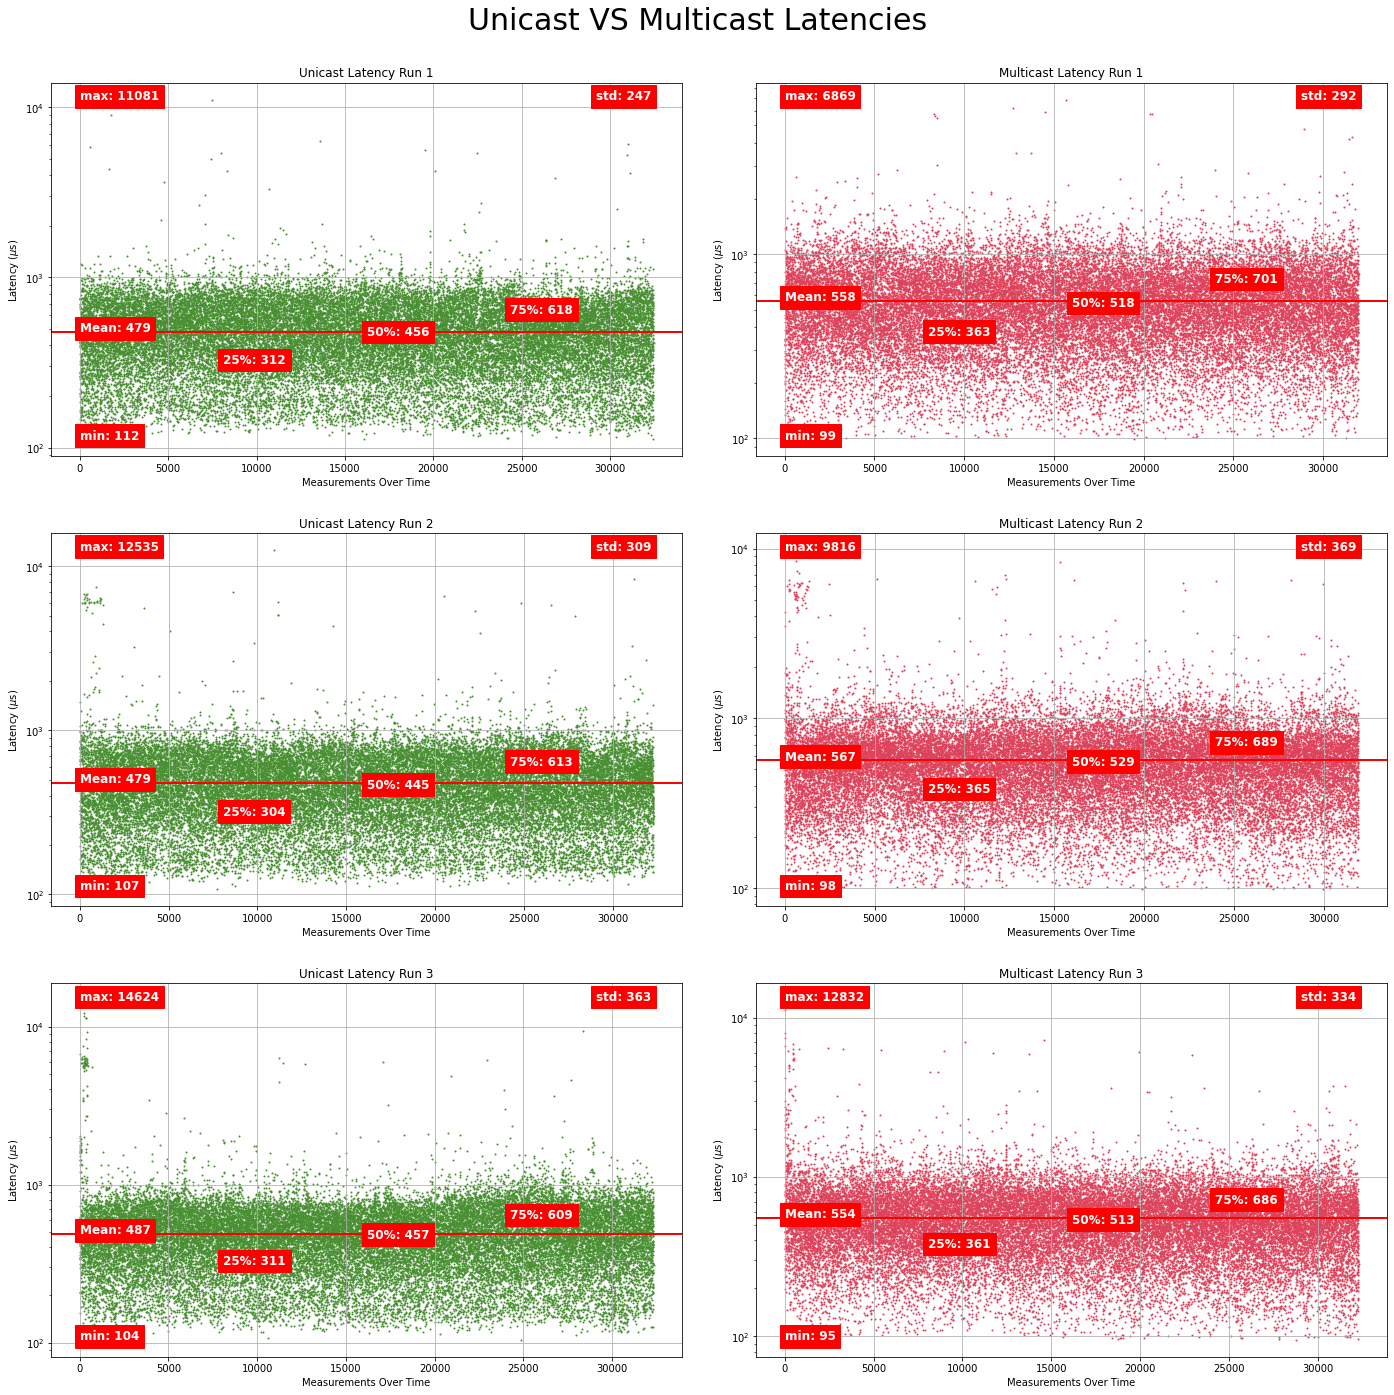

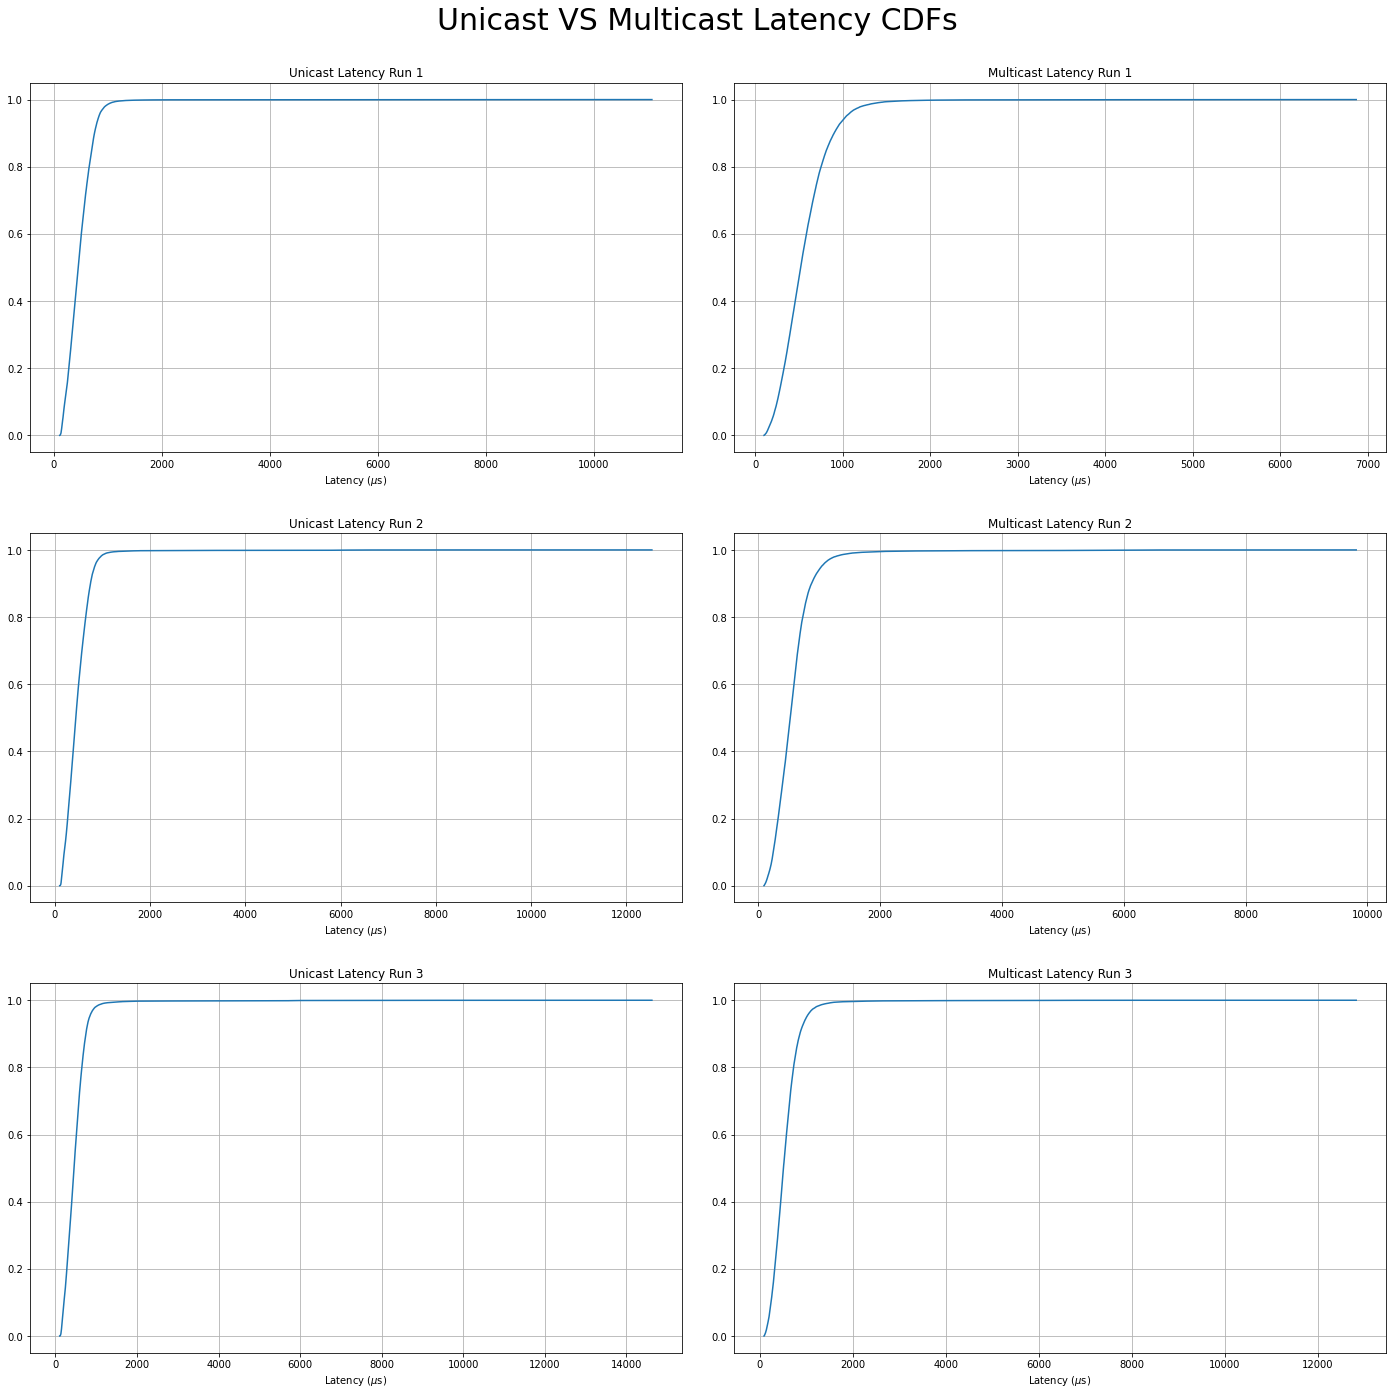

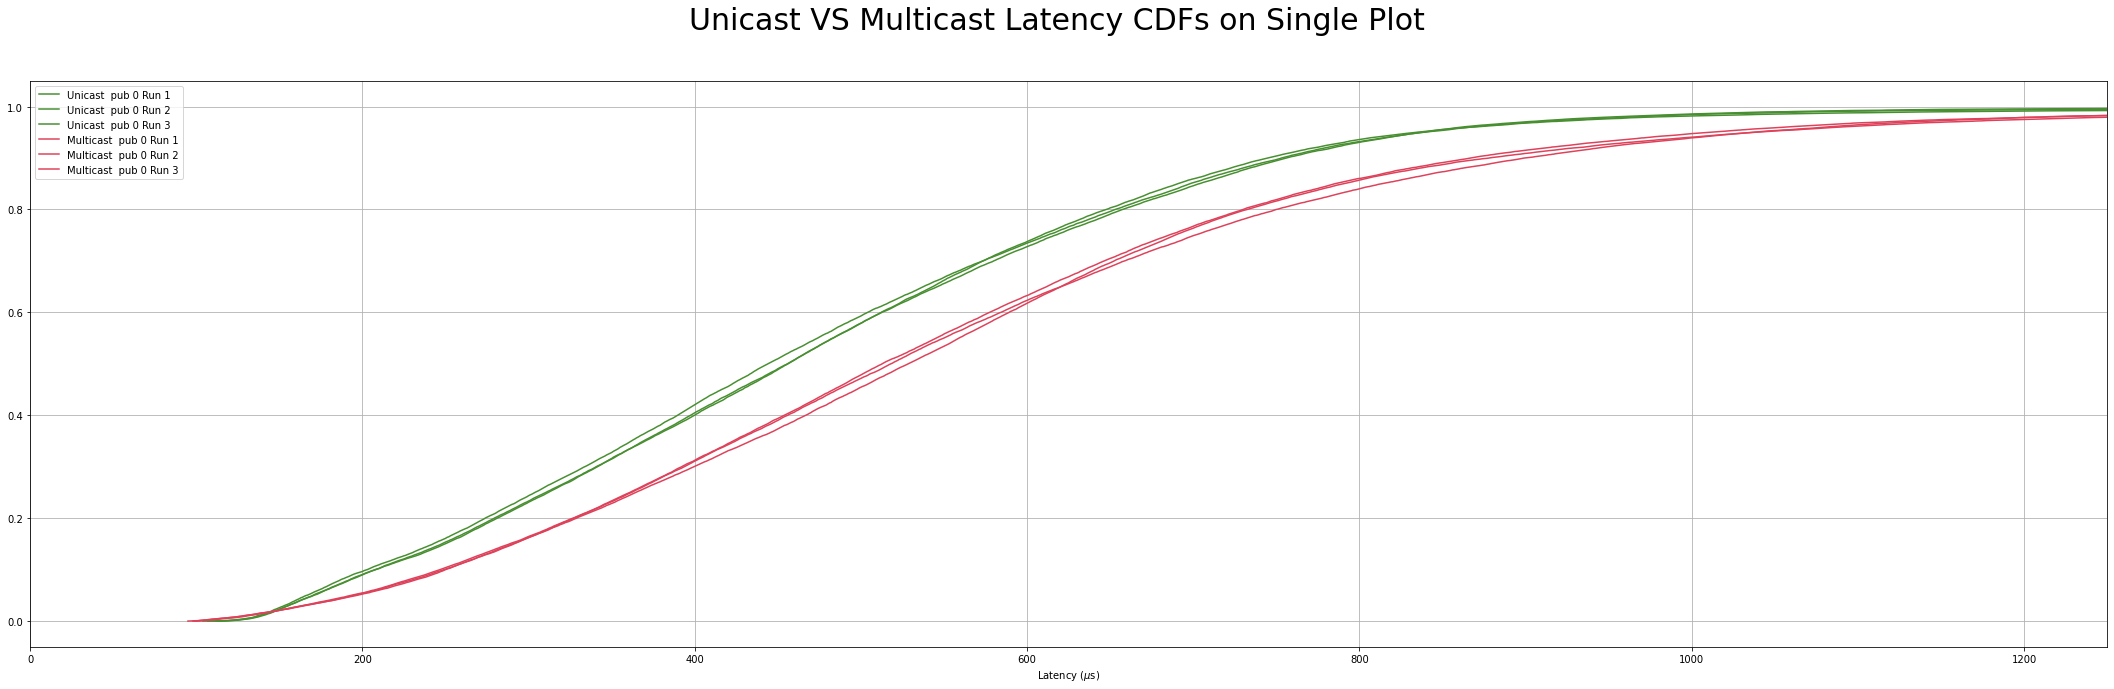

In [2]:
unicast_latency_files = get_latency_files(unicast_files)
unicast_latency_files.sort()
multicast_latency_files = get_latency_files(multicast_files)
multicast_latency_files.sort()

figure, axes = plt.subplots(nrows=3, ncols=2, figsize=(20, 20))
figure.suptitle("Unicast VS Multicast Latencies", fontsize=30)
multi_plot_data(unicast_latency_files, multicast_latency_files, "Unicast Latency", "Multicast Latency", '')
plt.tight_layout(pad=3)

figure, axes = plt.subplots(nrows=3, ncols=2, figsize=(20, 20))
figure.suptitle("Unicast VS Multicast Latency CDFs", fontsize=30)
multi_plot_data(unicast_latency_files, multicast_latency_files, "Unicast Latency", "Multicast Latency", 'cdf')
plt.tight_layout(pad=3)

figure, ax = plt.subplots(figsize=(30, 10))
figure.suptitle("Unicast VS Multicast Latency CDFs on Single Plot", fontsize=30)
plot_all_latency_cdf_on_one("Unicast", unicast_latency_files, ax)
plot_all_latency_cdf_on_one("Multicast", multicast_latency_files, ax)
plt.tight_layout(pad=3)

## Unicast VS Multicast Throughput

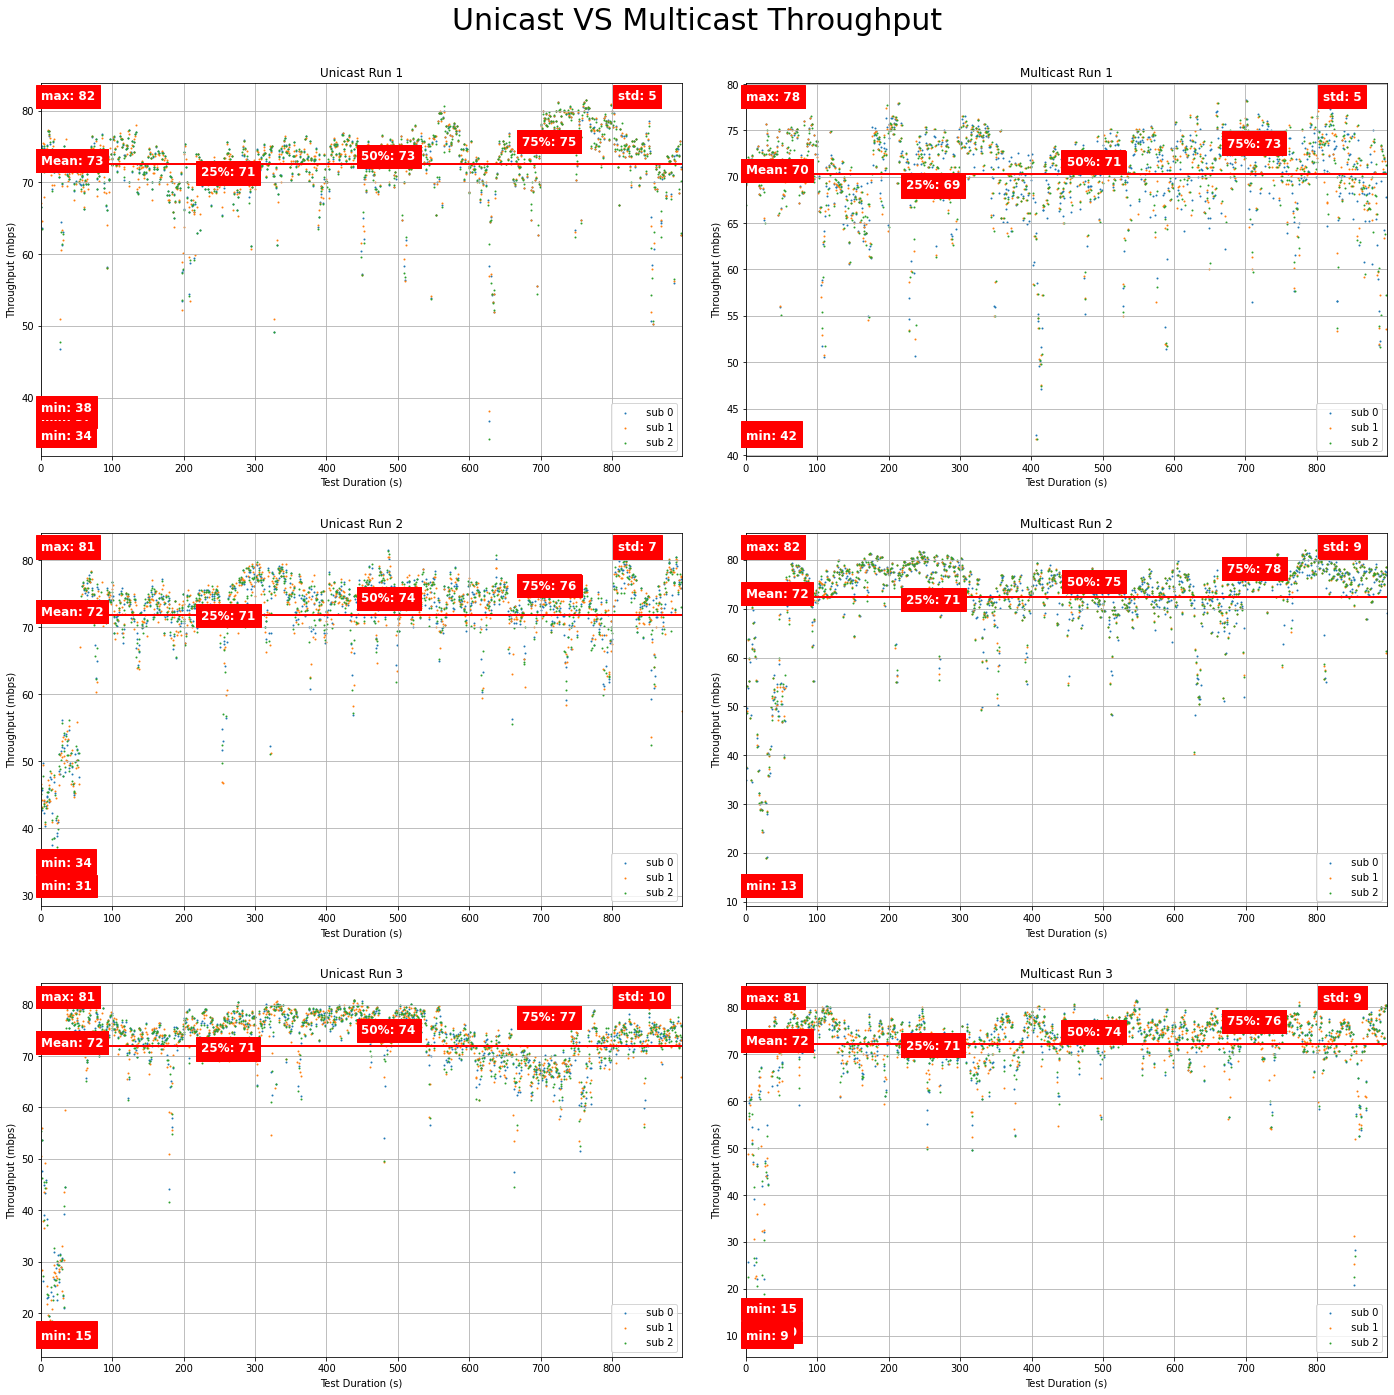

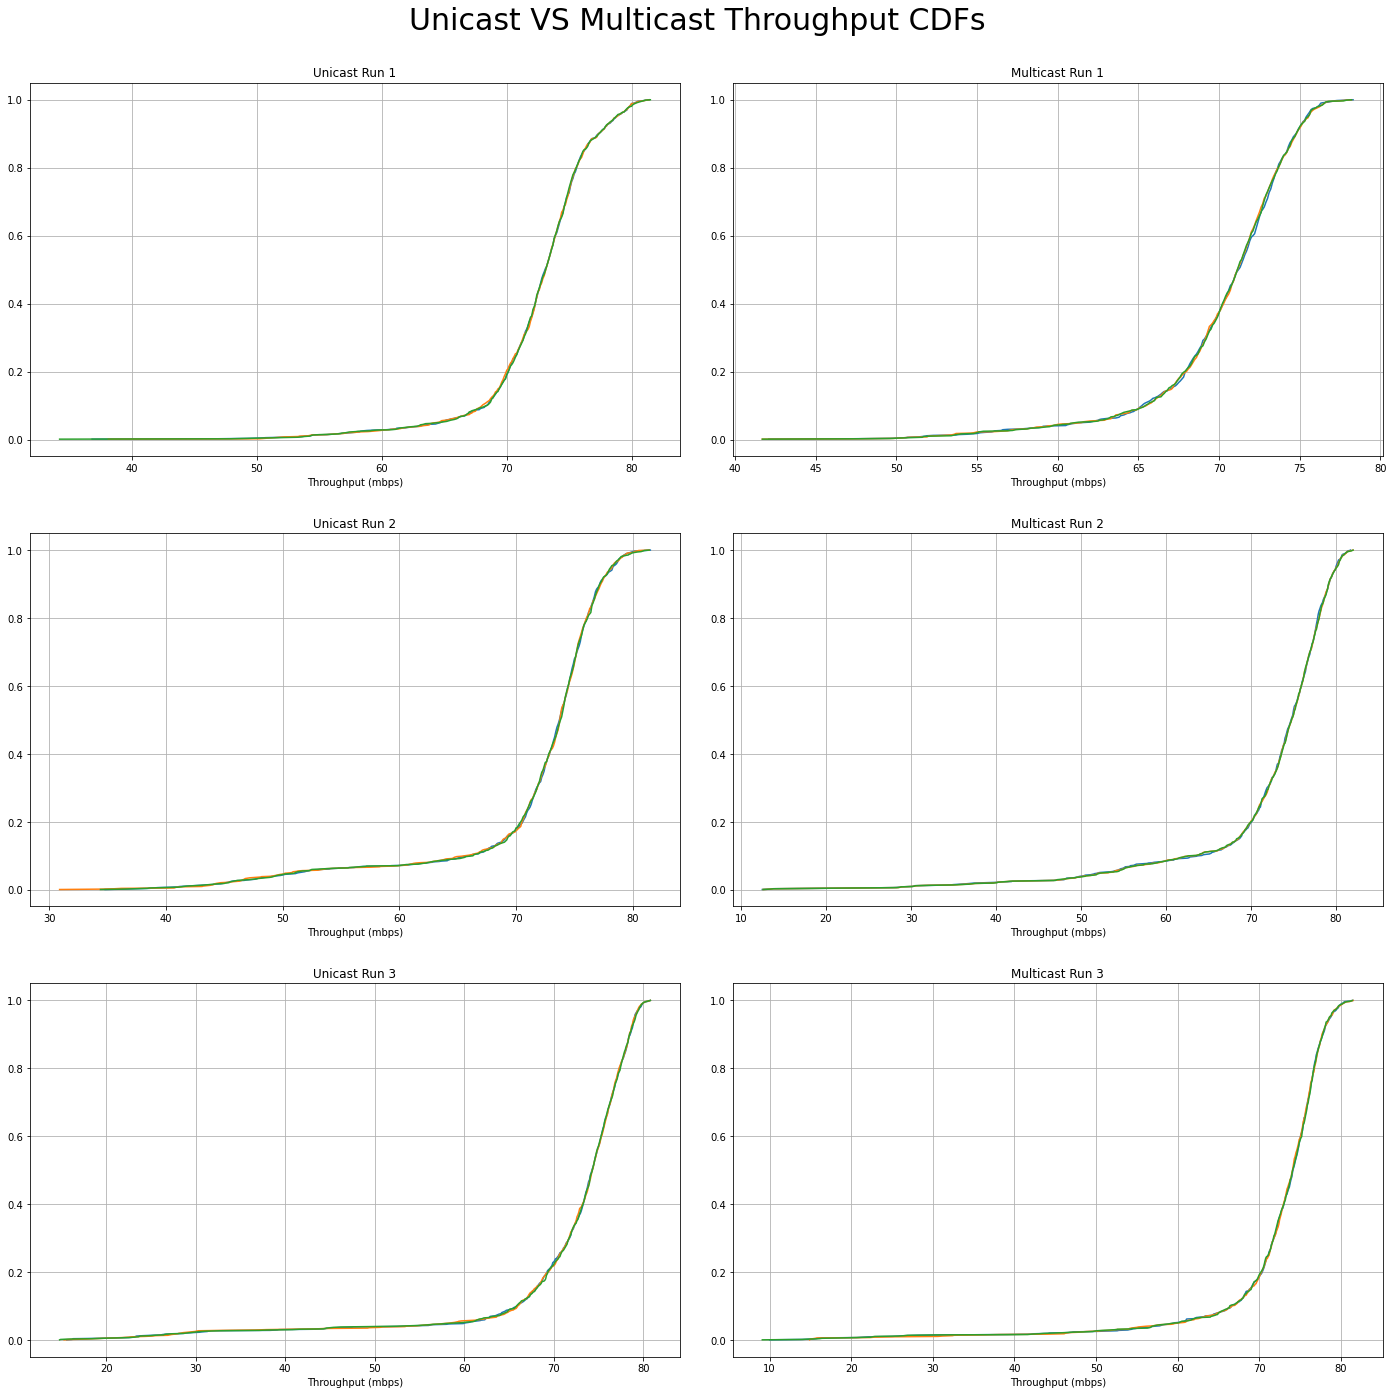

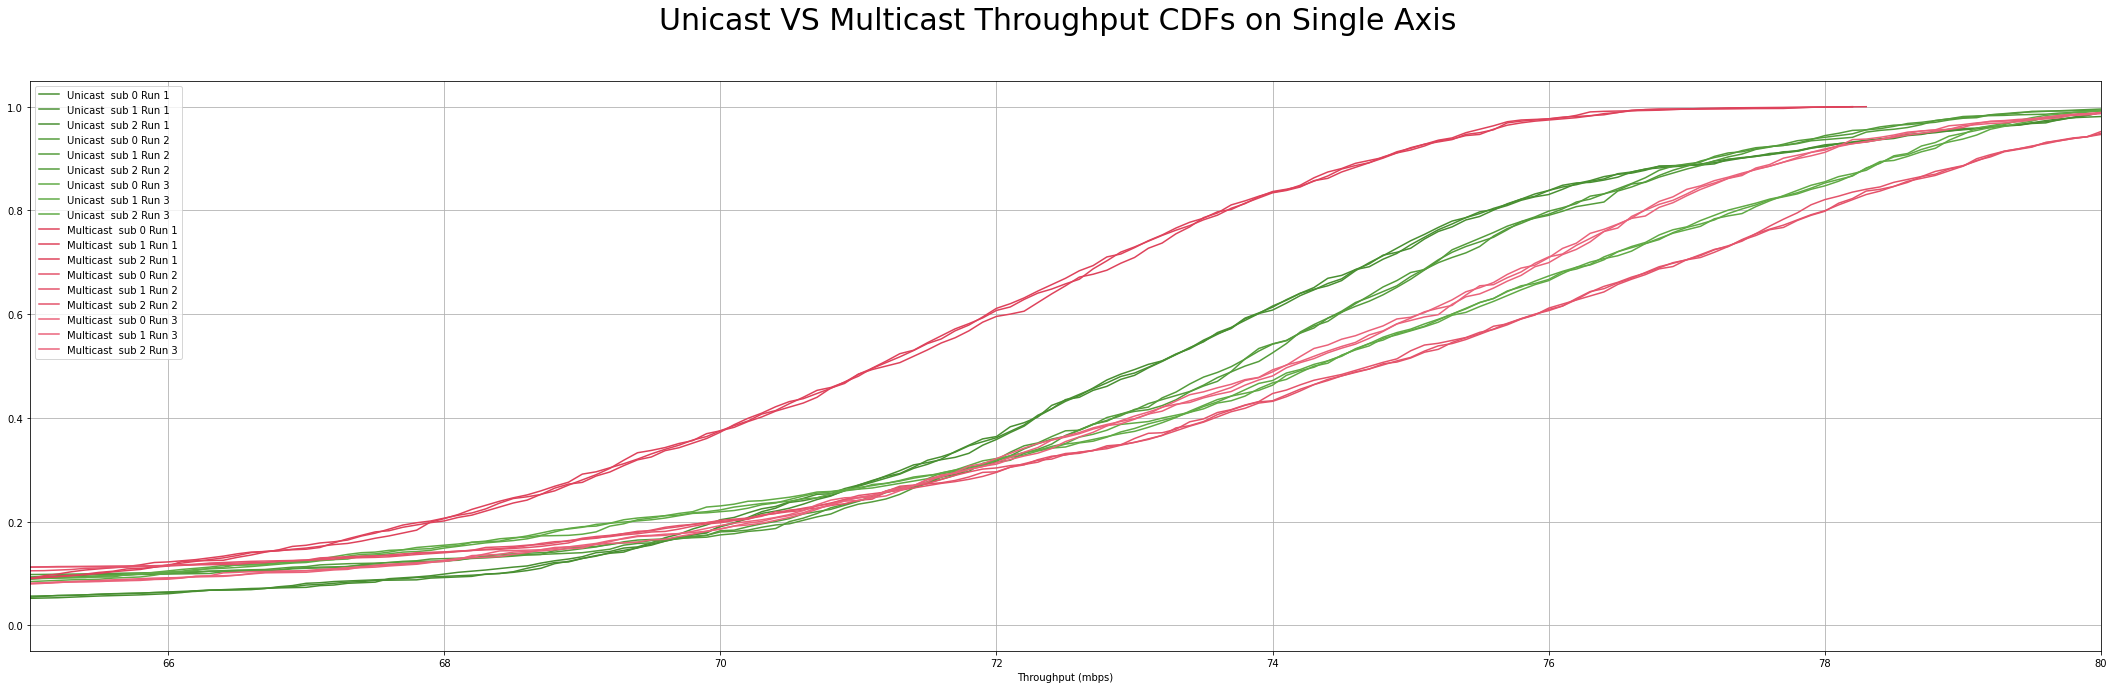

In [3]:
unicast_throughput_files = [file for file in unicast_files if "sub_" in file]
unicast_throughput_files.sort()
multicast_throughput_files = [file for file in multicast_files if "sub_" in file]
multicast_throughput_files.sort()

run_count = get_run_count(unicast_throughput_files)

figure, axes = plt.subplots(nrows=run_count, ncols=2, figsize=(20, 20))
figure.suptitle("Unicast VS Multicast Throughput", fontsize=30)
multiplot_throughput("Unicast", "Multicast", unicast_throughput_files, multicast_throughput_files, axes)
plt.tight_layout(pad=3)

figure, axes = plt.subplots(nrows=run_count, ncols=2, figsize=(20, 20))
figure.suptitle("Unicast VS Multicast Throughput CDFs", fontsize=30)
multiplot_throughput_cdf("Unicast", "Multicast", unicast_throughput_files, multicast_throughput_files, axes)
plt.tight_layout(pad=3)

greens = ['#488f31', '#549c3b', '#60aa45', '#6db850', '#79c65a', '#86d465', '#93e26f', '#a0f07a', '#adff85']
reds = ['#de425b', '#e4536b', '#ea627a', '#ee718a', '#f38099', '#f68fa7', '#fa9db5', '#fcabc2', '#ffb9cf']

figure, ax = plt.subplots(figsize=(30, 10))
figure.suptitle("Unicast VS Multicast Throughput CDFs on Single Axis", fontsize=30)
plot_all_throughput_cdf_on_one("Unicast", unicast_throughput_files, ax, greens)
plot_all_throughput_cdf_on_one("Multicast", multicast_throughput_files, ax, reds)
plt.tight_layout(pad=3)